In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

In [2]:
# Load image helpers
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

In [3]:
# Gram matrix helper
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations


In [4]:
# VGG19 layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [5]:
# Load VGG19 model
def get_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return tf.keras.Model(vgg.input, model_outputs)


In [6]:
# Extract features
def get_feature_representations(model, content_path, style_path):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer for content_layer in content_outputs[num_style_layers:]]

    return style_features, content_features

In [7]:
# Compute loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Style loss
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        gram_comb_style = gram_matrix(comb_style)
        style_score += tf.reduce_mean((gram_comb_style - target_style)**2)

    style_score /= num_style_layers

    # Content loss
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean((comb_content - target_content)**2)

    content_score /= num_content_layers

    total_loss = style_weight * style_score + content_weight * content_score
    return total_loss, style_score, content_score


In [8]:
# Compute gradients
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss


In [23]:
# Main style transfer run function
def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3,
                       style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5.0)
    
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    display_interval = 100

    start_time = time.time()

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()

        if i % display_interval == 0:
            print(f"Iteration {i}: total loss={loss:.4e}, style loss={style_score:.4e}, content loss={content_score:.4e}")

    end_time = time.time()
    print(f"Total time: {end_time - start_time:.4f}s")
    best_img, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)
    return best_img, best_loss

In [25]:
# Provide your image paths here
content_path = "/Users/sowmyapujari31/Downloads/pexels-jarod-17350906.jpg"
style_path = "/Users/sowmyapujari31/Downloads/pexels-jarod-17350906.jpg"

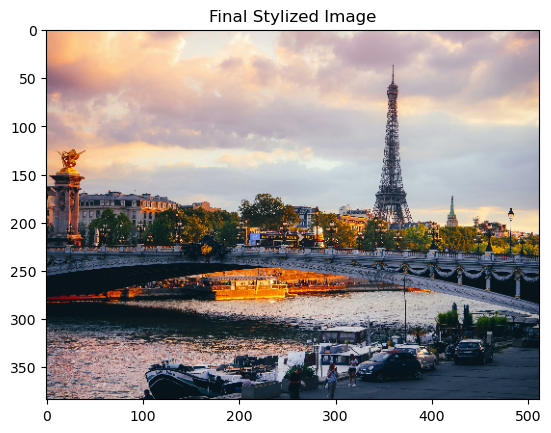

In [27]:
# Show result
final_img = tf.image.convert_image_dtype(best_img, tf.uint8)
imshow(final_img, "Final Stylized Image")